# Hop Teaming Analysis - Geospatial Analysis

## Team: The Hindenburgs

![The Hindenburgs](../img/the_hindenburgs_propaganda.png)

In [59]:
import pandas as pd
import sqlite3
import requests
import matplotlib.pyplot as plt
import json
import time
import geopandas as gpd
from shapely.geometry import Point
import shapely
from matplotlib.colors import ListedColormap
import numpy as np

In [2]:
louvain_community = pd.read_csv('../data/louvain_community.csv')

Only 22 communities have 10 or more NPIs within and they correspond to 7788 NPIs (out of a total 8308, so only missing 520)

In [3]:
npi_communities = tuple(louvain_community['name'].tolist())

query =f"""
SELECT *
FROM nnpes
WHERE npi IN {npi_communities}
"""


with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    communities = pd.read_sql(query, db)

communities.head()

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy
0,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,None,CLARKSVILLE,TN,37043,207Q00000X
1,1003013947,1.0,None,OTTO,ROBERT,JOEL,DR.,None,M.D.,2400 PATTERSON ST STE 100,None,NASHVILLE,TN,37203,207X00000X
2,1003019902,1.0,None,ACOSTA,LEALANI,MAE,None,None,MD,3601 TVC,None,NASHVILLE,TN,37232,2084N0400X
3,1003028770,2.0,SPRING HILL DERMATOLOGY PLC,None,None,None,None,None,None,1229 RESERVE BLVD,SUITE 200,SPRING HILL,TN,37174,207N00000X
4,1003031261,1.0,None,RUBRIGHT,JAMES,HARDMAN,None,None,M.D.,345 23RD AVE N,SUITE 212,NASHVILLE,TN,37203,207XS0106X


In [4]:
communities = pd.merge(left = communities, right = louvain_community, 
                        left_on = 'npi', right_on = 'name')

communities = communities.drop(columns='name')

In [5]:
# adding the two new columns that will have the lat and long
communities['lat'] = ''
communities['lng'] = ''

Now "communities" contains the NPIs and addresses of interest.

## Openstreetmap (nominatim) Approach

The code is all commented, because using openstreetmaps takes about an hour to run. I found out that using Google is much faster (about 3x). Furthermore, for openstreetmaps there is a need for additional formating because some addresses have "Suite" or "Appartment" in first line address (instead of second line as it should be).

On top of that, Openstreetmap didn't find about 2000 of the addresses in the list.

In [6]:
# This below is needed because around 1250 addresses have STE in the first address line and that is not usable with nominatim openstreetmap
# communities['first_line_address'] = communities['first_line_address'].str.replace(' STE.+', '', regex=True)

# another 104 that end in ST + number
# communities['first_line_address'] = communities['first_line_address'].str.replace(' ST\d.+', '', regex=True)

# 7 with appartments
# communities['first_line_address'] = communities['first_line_address'].str.replace(' APT.', '', regex=True)

In [7]:
# def latlong_go_getter(street, city, state, zip):
#     endpoint = 'https://nominatim.openstreetmap.org/search'

#     params = {
#     'street' : street,
#     'city' : city,
#     'state' : state,
#     'postalcode' : zip,
#     'format' : 'json'
#     }
    
#     response = requests.get(endpoint, params = params)
#     tm=0

#     while response.status_code != 200:
#         print('waiting for ' + street)
#         time.sleep(10)
#         response = requests.get(endpoint, params = params)
#         tm = tm + 1
#         if tm == 10:
#             break

#     results = response.json()

#     if results:
#         return results[0]['lat'], results[0]['lon']
#     else:
#         return '', ''


In [8]:
# communities[['lat', 'lng']] = communities.apply(lambda row: pd.Series(latlong_go_getter(row['first_line_address'], row['address_city_name'], row['address_state_name'], row['address_postal_code'])), axis=1)

## Google approach

**WARNING:** In order to use google's API, you need to create a dev account (if not having one already) and obtain the API key. Google gives $200 worth of credits per month. In order to obtain the addresses for the 8000 APIs, that will consume about $40 of it.

In [9]:
with open('../keys.json') as fi:
    credentials = json.load(fi)

In [10]:
api_key = credentials['api_key']

In [11]:
def latlong_googler(street, city, state, zip):
    endpoint = 'https://maps.googleapis.com/maps/api/geocode/json'

    params = {
    'address' : street + ', ' + city  + ', ' + state  + ', ' + zip,
    'key' : api_key
    }
    
    response = requests.get(endpoint, params = params)
    tm=0

    while response.status_code != 200:
        print('waiting for ' + street)
        time.sleep(10)
        response = requests.get(endpoint, params = params)
        tm = tm + 1
        if tm == 10:
            break

    results = response.json()

    if results:
        return results['results'][0]['geometry']['location']['lat'], results['results'][0]['geometry']['location']['lng']
    else:
        return '', ''

The code below takes about 20 min to run, so it's commented out! Only needs to be ran once and then saved to csv.

In [12]:
#communities[['lat', 'lng']] = communities.apply(lambda row: pd.Series(latlong_googler(row['first_line_address'], row['address_city_name'], row['address_state_name'], row['address_postal_code'])), axis=1)

In [13]:
#communities.to_csv('../data/communities_googlemap.csv')

> NOTE: I initially ran this only on large communities. That is why I had to add two files together below and concatenate them:

In [14]:
small_communities = pd.read_csv('../data/small_communities_googlemap.csv').drop(columns='Unnamed: 0')
communities = pd.read_csv('../data/communities_googlemap.csv').drop(columns='Unnamed: 0')

In [15]:
communities = pd.concat([small_communities,communities])

In [16]:
communities.head()

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy,communityId,lat,lng
0,1003297318,1.0,NaN,GOZUM,VIRGILIO,P,DR.,NaN,O.D.,5238 MAIN ST,NaN,SPRING HILL,TN,37174,152W00000X,4270,35.754979,-86.925748
1,1003359233,2.0,"BERRY FARMS EYECARE, PLLC",NaN,NaN,NaN,NaN,NaN,NaN,40 MOSS LN STE 110,NaN,FRANKLIN,TN,37064,152W00000X,8003,35.861637,-86.844781
2,1003875824,1.0,NaN,SANDS,ALADRAINE,NaN,NaN,NaN,M.D.,275 CUMBERLAND BND,NaN,NASHVILLE,TN,37228,207R00000X,4558,36.193784,-86.787897
3,1003890609,1.0,NaN,JOHNSON,TRAVIS,M.,DR.,NaN,O.D.,140 JOE B JACKSON PKWY,NaN,MURFREESBORO,TN,37127,152W00000X,7944,35.775151,-86.399903
4,1013116169,2.0,FRANKLIN CHIROPRACTIC CENTER LLC,NaN,NaN,NaN,NaN,NaN,NaN,128 HOLIDAY CT STE 107,NaN,FRANKLIN,TN,37067,111N00000X,502,35.917912,-86.824578


## Obtaining the CBSA and counties Shapefiles

Downloaded the CBSA shapefile from [catalog data gov](https://catalog.data.gov/dataset/tiger-line-shapefile-2020-nation-u-s-core-based-statistical-areas-cbsa)

In [17]:
# load in ALL of the CBSA (from all of the US)
cbsa_34980 = gpd.read_file('../data/tl_2020_us_cbsa/tl_2020_us_cbsa.shp')

# select only the one we're interested in, for the Nashville general area
cbsa_34980 = cbsa_34980.loc[cbsa_34980['CBSAFP'] == '34980']

In [18]:
counties = gpd.read_file('../data/tl_2016_47_cousub/tl_2016_47_cousub.shp')

In [19]:
counties.head(5)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,053,90054,02464232,4705390054,1,District 1,28,Z1,G4040,None,None,None,N,96264311,137578,+35.8364702,-088.7717523,"POLYGON ((-88.84931 35.84546, -88.84925 35.846..."
1,47,053,91764,02464308,4705391764,10,District 10,28,Z1,G4040,None,None,None,N,10508081,0,+35.9588678,-088.9411265,"POLYGON ((-88.95553 35.96024, -88.95544 35.960..."
2,47,053,91954,02464338,4705391954,11,District 11,28,Z1,G4040,None,None,None,N,217597201,1369276,+35.9897003,-088.7783091,"POLYGON ((-88.89445 35.95602, -88.89384 35.956..."
3,47,053,92144,02464357,4705392144,12,District 12,28,Z1,G4040,None,None,None,N,31322917,7879,+35.8879687,-088.7372825,"POLYGON ((-88.79699 35.88976, -88.79654 35.889..."
4,47,059,90630,02464038,4705990630,4,District 4,28,Z1,G4040,None,None,None,N,229945651,1986997,+36.0742786,-082.7712694,"POLYGON ((-82.86306 36.06660, -82.86237 36.067..."


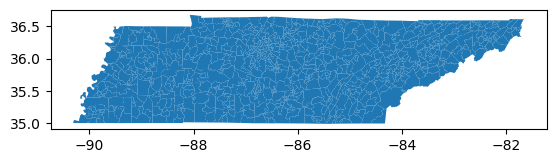

In [20]:
counties.plot();

## Louvain Communities in Geopandas

In [21]:
communities_by_size = (
    louvain_community
    .groupby('communityId')
    .count()
    .sort_values(by='name', ascending=False)
    .reset_index()
    .rename(columns={'name': 'npi_count'})
)

communities_by_size['size_ranked'] = communities_by_size['npi_count'].rank(method='min', ascending=False).astype(int)

The communities by size dataframe is used to reference the communities of interest (for example, the largest ones).

In [22]:
# create the geometry in order to convert to geopandas
communities['geometry'] = gpd.points_from_xy(communities['lng'], communities['lat'])

communities.head()

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy,communityId,lat,lng,geometry
0,1003297318,1.0,NaN,GOZUM,VIRGILIO,P,DR.,NaN,O.D.,5238 MAIN ST,NaN,SPRING HILL,TN,37174,152W00000X,4270,35.754979,-86.925748,POINT (-86.92575 35.75498)
1,1003359233,2.0,"BERRY FARMS EYECARE, PLLC",NaN,NaN,NaN,NaN,NaN,NaN,40 MOSS LN STE 110,NaN,FRANKLIN,TN,37064,152W00000X,8003,35.861637,-86.844781,POINT (-86.84478 35.86164)
2,1003875824,1.0,NaN,SANDS,ALADRAINE,NaN,NaN,NaN,M.D.,275 CUMBERLAND BND,NaN,NASHVILLE,TN,37228,207R00000X,4558,36.193784,-86.787897,POINT (-86.78790 36.19378)
3,1003890609,1.0,NaN,JOHNSON,TRAVIS,M.,DR.,NaN,O.D.,140 JOE B JACKSON PKWY,NaN,MURFREESBORO,TN,37127,152W00000X,7944,35.775151,-86.399903,POINT (-86.39990 35.77515)
4,1013116169,2.0,FRANKLIN CHIROPRACTIC CENTER LLC,NaN,NaN,NaN,NaN,NaN,NaN,128 HOLIDAY CT STE 107,NaN,FRANKLIN,TN,37067,111N00000X,502,35.917912,-86.824578,POINT (-86.82458 35.91791)


In [23]:
# create geopandas from pandas with the geometry created in previous step
communities_geo = gpd.GeoDataFrame(communities, 
                                    crs = cbsa_34980.crs, 
                                    geometry = communities['geometry'])

In [24]:
# bring in the size of the communities
communities_geo = communities_geo.merge(communities_by_size, left_on='communityId', right_on='communityId')

In [25]:
topcommunities_geo = communities_geo.loc[communities_geo['size_ranked'] <= 5]

topcommunities_geo['size_ranked'] = topcommunities_geo['size_ranked'].astype('category')

/Users/tomoumer/opt/anaconda3/envs/geospatial_ds6/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In order to plot the communities, have to filter for counties that contain them. Obtained the information from Wikipedia.

> NOTE: the top 5 communities don't reach to Coffee and Humphreys; but those two counties are present in some other smaller communities

County codes:
| Conuty Name | Bedford | Davidson | Wilson | Williamson |Ruhterford | Marshall | Maury | Cannon | Dickson | Hickman | Giles | Coffee |
| ----------- | ------- | -------- | ------ | ---------- | --------- | -------- | ----- | ------ | ------- | ------- | ----- | ------ |
| County Code | 003     | 037      | 189    | 187        | 149       | 117      | 119   | 015    | 043     | 081     | 055   | 031    |

| County Name | Warren | DeKalb | Smith | Macon | Sumner | Trousedale | Robertson | Montgomery | Cheatham | Lawrence | Humphreys |
| ----------- | ------ | ------ | ----- | ----- | ------ | ---------- | --------- | ---------- | -------- | -------- | --------- |
| County Code | 177    | 041    | 159   | 111   | 165    | 169        | 147       | 125        | 021      | 099      | 085       |



In [26]:
relevant_counties = ['003', '015', '021', '037', '041', '043', '055', '081', '099', '111', '117', '119', '125', '147', '159', '165', '169', '177', '189', '187', '149', '031', '085']

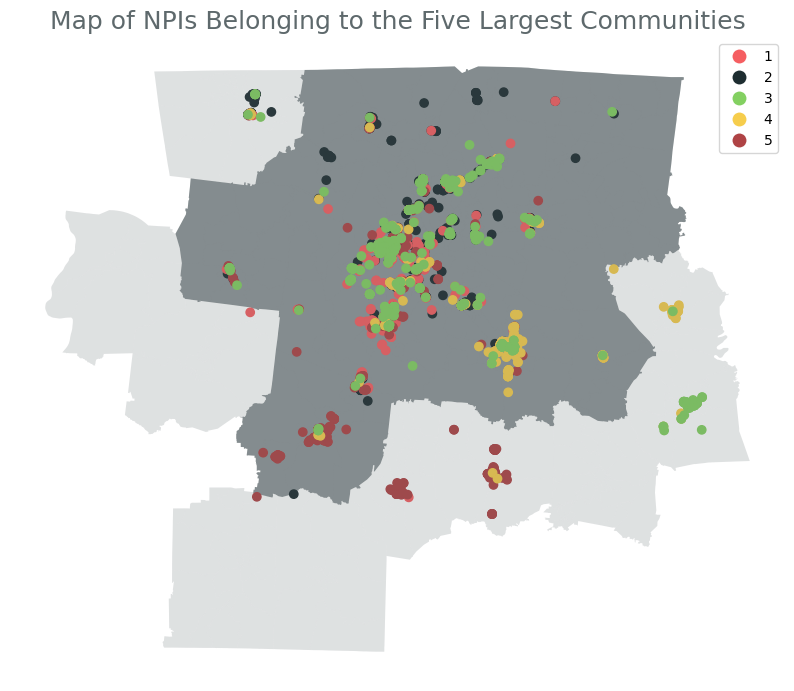

In [27]:
ax = cbsa_34980.plot(figsize=(10,10), color = '#5E696C', alpha=0.7)
topcommunities_geo.loc[topcommunities_geo['lng'] < -84].plot(ax = ax, column= 'size_ranked', cmap = ListedColormap(['#F55E61', '#1E2D31', '#83D061', '#F6CD4C', '#AF4345']), legend='True') #edgecolor = 'black' 
counties.loc[counties['COUNTYFP'].isin(relevant_counties)].plot(ax=ax, color = '#5E696C', alpha=0.2)
plt.title('Map of NPIs Belonging to the Five Largest Communities', fontsize = 18, color='#5E696C')
ax.axis('off');

The calculations below are used to determine for each county the number of NPIs within a community that a Vanderbilt hospital is part of (That is, the largest, 5th largest and 7th largest community), with respect to the total number of NPIs in that county.

It goes as follows:
- place all the NPIs (total & Vanderbilt-community affiliated) within each county, using geopandas magic
- count the number of each (total & Vanderbilt-communit affiliated) within each county
- take out the counties of interest (as defined above)
    - note that there are counties with 0 Vanderbilt-community NPIs, so those values have to be filled with 0
- define custom color map gradient to fit our (The Hindenburgs) presentation style
- draw map!


In [28]:
npis_by_county = gpd.sjoin(communities_geo, counties, predicate = 'within')

# these three below have a vandy hospital in (the first largest, fifth and seventh)
# the result was obtained in the "community_detection" jupyter notebook
vandynpis_by_county = gpd.sjoin(communities_geo.loc[communities_geo['size_ranked'].isin([1,5,7])], counties, predicate = 'within')

In [29]:
npis_by_county = npis_by_county['COUNTYFP'].value_counts().to_frame().reset_index().rename(columns={'index':'COUNTYFP', 'COUNTYFP':'count_npi'})
vandynpis_by_county = vandynpis_by_county['COUNTYFP'].value_counts().to_frame().reset_index().rename(columns={'index':'COUNTYFP', 'COUNTYFP':'count_vandynpi'})

In [30]:
interesting_counties = counties.loc[counties['COUNTYFP'].isin(relevant_counties)]

In [31]:
interesting_counties = pd.merge(left = interesting_counties, right = npis_by_county, 
                    left_on = 'COUNTYFP', right_on = 'COUNTYFP')

interesting_counties = pd.merge(left = interesting_counties, right = vandynpis_by_county, 
                    left_on = 'COUNTYFP', right_on = 'COUNTYFP', how='left')

interesting_counties['count_vandynpi'] = interesting_counties['count_vandynpi'].fillna(0)

In [32]:
interesting_counties['vandy_share'] = interesting_counties['count_vandynpi'] / interesting_counties['count_npi']

In [33]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(67/256, 245/256, N) #94 #30
vals[:, 1] = np.linspace(74/256, 94/256, N) #105 #45
vals[:, 2] = np.linspace(77/256, 97/256, N) #108 #49



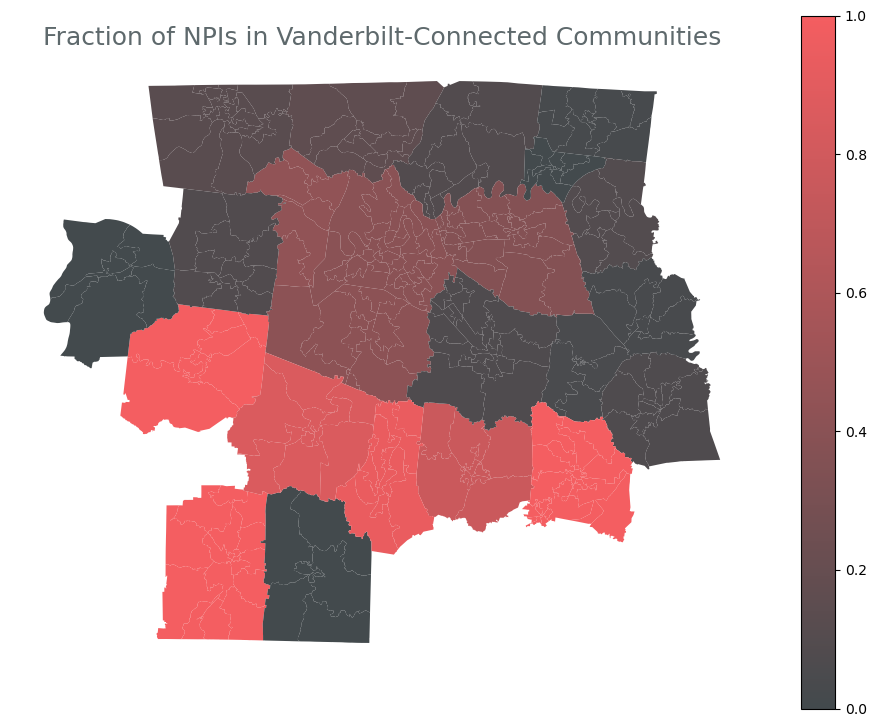

In [34]:
fig, ax = plt.subplots(figsize=(12,9))
interesting_counties.plot(column = 'vandy_share', cmap = ListedColormap(vals) , legend= True, ax = ax)
#cmap = ListedColormap(['#1E2D31','#273C42','#5E696C','#AF4345','#F55E61','#F58F8F','#83D061','#F6CD4C'])
plt.title('Fraction of NPIs in Vanderbilt-Connected Communities', fontsize = 18, color='#5E696C')
ax.axis('off');

From the map above it becomes quite evident the areas in which Vanderbilt might want to focus their attention on - from Northwest, North, Northeast and then into East.

## Visualizing single communities

I tried to use matplotlib animation but was not able to make it work with this particular setup.

Instead, decided to save the 22 pngs of the biggest communities and then turn that to an animation (by using [imagemagick](https://imagemagick.org/) for example).

Saved the animation in the /img/ folder.

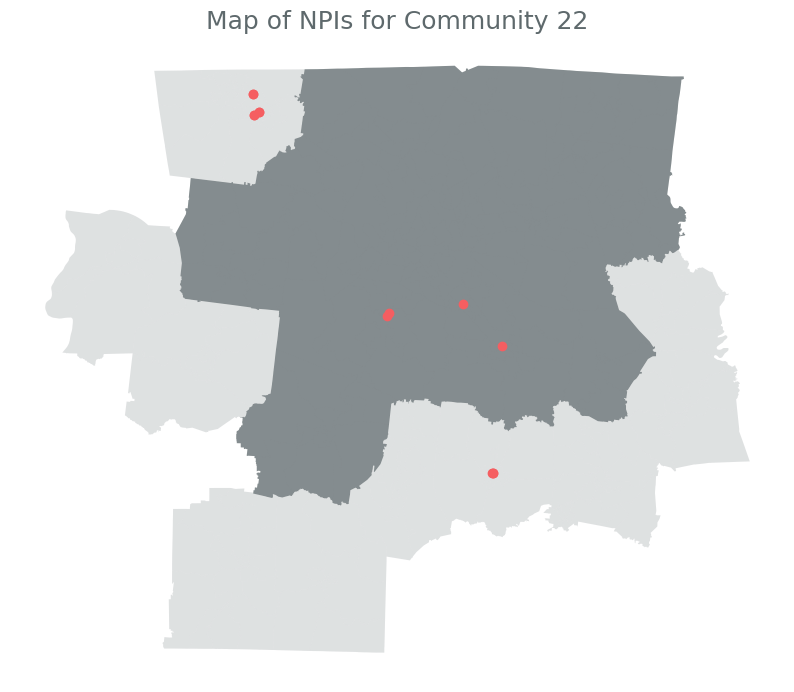

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
i = 0

for commid in (communities_by_size.head(22)['communityId']):
    i = i + 1
    ax.clear()
    cbsa_34980.plot(color = '#5E696C', alpha=0.7, ax=ax)
    counties.loc[counties['COUNTYFP'].isin(relevant_counties)].plot(ax=ax, color = '#5E696C', alpha=0.2)
    communities_geo.loc[(communities_geo['lng'] < -84) & (communities_geo['communityId'] == commid)].plot(ax = ax, color='#F55E61')
    plt.title(f'Map of NPIs for Community {i}', fontsize = 18, color='#5E696C')
    ax.axis('off')
    plt.savefig(f'../img/community_{str(i).zfill(2)}.png')
    
#plt.show()